In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np

import jax.numpy as jnp
from jax import grad, jit, random, partial, lax

import context
from models.bayesian_NN.NN_model import logprior, loglikelihood, init_network, accuracy_BNN
from models.bayesian_NN.NN_data import X_train, y_train, X_test, y_test
from models.bayesian_NN.util import load_NN_MAP, add_noise_NN_params

from tuning.mamba import timed_sampler
from tuning.ksd import imq_KSD
from tuning.util import build_metric_curve_fn, get_mean_sd_ksd_curve
from util import wait_until_computed, flatten_param_list

from sgmcmcjax.kernels import build_sgld_kernel, build_sghmc_kernel, build_sgnht_kernel
from sgmcmcjax.kernels import build_sgldCV_kernel, build_sghmcCV_kernel, build_sgnhtCV_kernel


# NN

In [2]:


data = (X_train, y_train)

key = random.PRNGKey(0)

Niters = 1000
key, subkey = random.split(key)
params_IC = add_noise_NN_params(subkey, load_NN_MAP(), 1.)
batch_size = int(0.1*X_train.shape[0])

gridsearch_bs = int(0.1*X_train.shape[0])
centering_value = load_NN_MAP()

# total time budget in mamba: 15sec

In [3]:
from sgmcmcjax.util import build_grad_log_post
from jax import vmap, jit

grad_log_post = build_grad_log_post(loglikelihood, logprior, data)


def get_fb_grads_NN(samples):
    """
    Return full-batch gradients for NN samples
    samples list of NN sample. Each NN sample is a list of tuples
    """
    return [grad_log_post(sam, X_train, y_train) for sam in samples]

def get_ksd_NN(samples, thin_step):
    num_samples = len(samples)
    fb_grads = get_fb_grads_NN(samples[::thin_step])
    flat_samples = flatten_param_list(samples[::thin_step])
    flat_grads = flatten_param_list(fb_grads)
    return imq_KSD(flat_samples, flat_grads)

def assess_NN_samples(samples, thin_step):
    print(f"Assessing the samples. Num samples: {len(samples)}")
    ksd_est = get_ksd_NN(samples, thin_step)
    return ksd_est
#     samples_array = jnp.array(samples[::thin_step])
#     pred_acc = accuracy(samples_array, X_test, y_test)
#     return ksd_est, pred_acc, std_error, len(samples)
    
def run_time_budget(key, time_budget, build_kernel, thin, dict_params, params_IC=load_NN_MAP()):
    timed_sampler_factory = timed_sampler(build_kernel)
    my_timed_sampler = timed_sampler_factory(**dict_params)
    samples, _ = my_timed_sampler(key, time_budget, params_IC)
    return assess_NN_samples(samples, thin)



### build partial kernels

In [4]:
partial_build_sgld = lambda dt, batch_size: build_sgld_kernel(dt, loglikelihood, 
                                                              logprior, data, batch_size)
partial_build_sgldCV = lambda dt, batch_size: build_sgldCV_kernel(dt, loglikelihood, 
                                                    logprior, data, batch_size, centering_value)

partial_build_sghmc = lambda dt, L, batch_size: build_sghmc_kernel(dt, L, loglikelihood, 
                                                              logprior, data, batch_size)
partial_build_sghmcCV = lambda dt, L, batch_size: build_sghmcCV_kernel(dt, L, loglikelihood, 
                                                              logprior, data, batch_size, centering_value)

partial_build_sgnht = lambda dt, batch_size: build_sgnht_kernel(dt, loglikelihood, 
                                                              logprior, data, batch_size)
partial_build_sgnhtCV = lambda dt, batch_size: build_sgnhtCV_kernel(dt, loglikelihood, 
                                                              logprior, data, batch_size, centering_value)


time_budget = 20
thin = 20


# 1. A long run

- 1 million data points
- 20sec budget
- thin by 20

In [5]:
sh_params = {'batch_size': 600, 'dt': 1e-05}
gridsearch_params = {'batch_size': gridsearch_bs, 'dt': 0.00031622776}

print(run_time_budget(key, time_budget, partial_build_sgld, thin, sh_params))
print(run_time_budget(key, time_budget, partial_build_sgld, thin, gridsearch_params))

assessing the samples. Num samples: 38098
(DeviceArray(58.74838, dtype=float32), DeviceArray(0.93894, dtype=float32), 0.6776350647278283, 38098)
assessing the samples. Num samples: 6963
(DeviceArray(95.22943, dtype=float32), DeviceArray(0.938975, dtype=float32), 0.1827750216747604, 6963)


In [6]:
sh_params = {'batch_size': 600, 'dt': 1e-05}
gridsearch_params = {'batch_size': gridsearch_bs, 'dt': 0.00031622776}

print(run_time_budget(key, time_budget, partial_build_sgldCV, thin, sh_params))
print(run_time_budget(key, time_budget, partial_build_sgldCV, thin, gridsearch_params))

(DeviceArray(6.3601794, dtype=float32), DeviceArray(0.9374, dtype=float32), 119847)
(DeviceArray(9.605597, dtype=float32), DeviceArray(0.93754995, dtype=float32), 40236)


In [7]:
sh_params = {'batch_size': 60000, 'L': 10, 'dt': 1e-07}
gridsearch_params = {'batch_size': gridsearch_bs, 'L': 10, 'dt': 1e-}

print(run_time_budget(key, time_budget, partial_build_sghmc, thin, sh_params))
print(run_time_budget(key, time_budget, partial_build_sghmc, thin, gridsearch_params))

(DeviceArray(21.923801, dtype=float32), DeviceArray(0.9374, dtype=float32), 13090)
(DeviceArray(35.149246, dtype=float32), DeviceArray(0.93754995, dtype=float32), 7291)


In [8]:
sh_params = {'batch_size': 600, 'L': 5, 'dt': 1e-06}
gridsearch_params = {'batch_size': gridsearch_bs, 'L': 10, 'dt': }

print(run_time_budget(key, time_budget, partial_build_sghmcCV, thin, sh_params))
print(run_time_budget(key, time_budget, partial_build_sghmcCV, thin, gridsearch_params))

(DeviceArray(7.422803, dtype=float32), DeviceArray(0.93745, dtype=float32), 60450)
(DeviceArray(18.989365, dtype=float32), DeviceArray(0.93759996, dtype=float32), 5860)


In [9]:
sh_params = {'batch_size': 60000, 'dt': 1e-05} 
gridsearch_params = {'batch_size': gridsearch_bs, 'dt': }

print(run_time_budget(key, time_budget, partial_build_sgnht, thin, sh_params))
print(run_time_budget(key, time_budget, partial_build_sgnht, thin, gridsearch_params))

(DeviceArray(16.316002, dtype=float32), DeviceArray(0.93745, dtype=float32), 49301)
(DeviceArray(15.97876, dtype=float32), DeviceArray(0.93745, dtype=float32), 49690)


In [10]:
sh_params = {'batch_size': 600, 'dt': 1e-07}
gridsearch_params = {'batch_size': gridsearch_bs, 'dt': }

print(run_time_budget(key, time_budget, partial_build_sgnhtCV, thin, sh_params))
print(run_time_budget(key, time_budget, partial_build_sgnhtCV, thin, gridsearch_params))

(DeviceArray(1.1308528, dtype=float32), DeviceArray(0.9375, dtype=float32), 42993)
(DeviceArray(2.036, dtype=float32), DeviceArray(0.93759996, dtype=float32), 36826)


# 2. KSD curves

### sgld

In [5]:
error_fn_ksd_curve = partial(get_ksd_NN, thin_step=10)
list_time_budget = [2, 4, 6, 8, 10]

num_curves = 10

In [6]:
dict_params = {'batch_size': 600, 'dt': 3.1622776e-06}
get_metric_curve = build_metric_curve_fn(dict_params, list_time_budget, 
                            partial_build_sgld, params_IC, error_fn_ksd_curve)

key = random.PRNGKey(0)
mean_ksd_curve_sgld_mamba, sd_ksd_curve_sgld_mamba = get_mean_sd_ksd_curve(key, num_curves, get_metric_curve)


Running for {'batch_size': 600, 'dt': 3.1622776e-06}

Iteration 0/10
Budget: 2, num_samples = 858
Budget: 4, num_samples = 1720
Budget: 6, num_samples = 1933
Budget: 8, num_samples = 3152
Budget: 10, num_samples = 3535

Iteration 1/10
Budget: 2, num_samples = 926
Budget: 4, num_samples = 1232
Budget: 6, num_samples = 2159
Budget: 8, num_samples = 3188
Budget: 10, num_samples = 4179

Iteration 2/10
Budget: 2, num_samples = 928
Budget: 4, num_samples = 1244
Budget: 6, num_samples = 2099
Budget: 8, num_samples = 3029
Budget: 10, num_samples = 4190

Iteration 3/10
Budget: 2, num_samples = 697
Budget: 4, num_samples = 884
Budget: 6, num_samples = 1629
Budget: 8, num_samples = 2774
Budget: 10, num_samples = 3615

Iteration 4/10
Budget: 2, num_samples = 843
Budget: 4, num_samples = 1037
Budget: 6, num_samples = 1904
Budget: 8, num_samples = 2821
Budget: 10, num_samples = 2494

Iteration 5/10
Budget: 2, num_samples = 882
Budget: 4, num_samples = 782
Budget: 6, num_samples = 1634
Budget: 8, num

In [17]:
dict_params = {'batch_size': gridsearch_bs, 'dt': 0.00031622776}
get_metric_curve = build_metric_curve_fn(dict_params, list_time_budget, 
                            partial_build_sgld, params_IC, error_fn_ksd_curve)

key = random.PRNGKey(0)
mean_ksd_curve_sgld_gridsearch, sd_ksd_curve_sgld_gridsearch = get_mean_sd_ksd_curve(key, num_curves, get_metric_curve)


Running for {'batch_size': 6000, 'dt': 0.00031622776}

Iteration 0/2
Budget: 2, num_samples = 124
Budget: 4, num_samples = 225
Budget: 6, num_samples = 315
Budget: 8, num_samples = 442
Budget: 10, num_samples = 527

Iteration 1/2
Budget: 2, num_samples = 73
Budget: 4, num_samples = 170
Budget: 6, num_samples = 351
Budget: 8, num_samples = 438
Budget: 10, num_samples = 474


### sgld-cv

In [7]:
dict_params = {'batch_size': 600, 'dt': 3.1622776e-06}
get_metric_curve = build_metric_curve_fn(dict_params, list_time_budget, 
                            partial_build_sgldCV, params_IC, error_fn_ksd_curve)

key = random.PRNGKey(0)
mean_ksd_curve_sgldCV_mamba, sd_ksd_curve_sgldCV_mamba = get_mean_sd_ksd_curve(key, num_curves, get_metric_curve)


Running for {'batch_size': 600, 'dt': 3.1622776e-06}

Iteration 0/10
Budget: 2, num_samples = 583
Budget: 4, num_samples = 680
Budget: 6, num_samples = 1137
Budget: 8, num_samples = 1811
Budget: 10, num_samples = 2171

Iteration 1/10
Budget: 2, num_samples = 390
Budget: 4, num_samples = 592
Budget: 6, num_samples = 1075
Budget: 8, num_samples = 1785
Budget: 10, num_samples = 2183

Iteration 2/10
Budget: 2, num_samples = 558
Budget: 4, num_samples = 618
Budget: 6, num_samples = 1142
Budget: 8, num_samples = 1834
Budget: 10, num_samples = 2444

Iteration 3/10
Budget: 2, num_samples = 599
Budget: 4, num_samples = 739
Budget: 6, num_samples = 998
Budget: 8, num_samples = 1430
Budget: 10, num_samples = 2216

Iteration 4/10
Budget: 2, num_samples = 505
Budget: 4, num_samples = 503
Budget: 6, num_samples = 1132
Budget: 8, num_samples = 1747
Budget: 10, num_samples = 2377

Iteration 5/10
Budget: 2, num_samples = 585
Budget: 4, num_samples = 754
Budget: 6, num_samples = 1175
Budget: 8, num_samp

In [18]:
dict_params = {'batch_size': gridsearch_bs, 'dt': 0.00031622776}
get_metric_curve = build_metric_curve_fn(dict_params, list_time_budget, 
                            partial_build_sgldCV, params_IC, error_fn_ksd_curve)

key = random.PRNGKey(0)
mean_ksd_curve_sgldCV_gridsearch, sd_ksd_curve_sgldCV_gridsearch = get_mean_sd_ksd_curve(key, num_curves, get_metric_curve)


Running for {'batch_size': 6000, 'dt': 0.00031622776}

Iteration 0/2
Budget: 2, num_samples = 76
Budget: 4, num_samples = 131
Budget: 6, num_samples = 194
Budget: 8, num_samples = 258
Budget: 10, num_samples = 332

Iteration 1/2
Budget: 2, num_samples = 62
Budget: 4, num_samples = 127
Budget: 6, num_samples = 196
Budget: 8, num_samples = 230
Budget: 10, num_samples = 300


### sghmc

In [8]:
dict_params = {'batch_size': 600, 'L': 5, 'dt': 3.1622776e-07}
get_metric_curve = build_metric_curve_fn(dict_params, list_time_budget, 
                            partial_build_sghmc, params_IC, error_fn_ksd_curve)

key = random.PRNGKey(0)
mean_ksd_curve_sghmc_mamba, sd_ksd_curve_sghmc_mamba = get_mean_sd_ksd_curve(key, num_curves, get_metric_curve)


Running for {'batch_size': 600, 'L': 5, 'dt': 3.1622776e-07}

Iteration 0/10
Budget: 2, num_samples = 199
Budget: 4, num_samples = 369
Budget: 6, num_samples = 435
Budget: 8, num_samples = 561
Budget: 10, num_samples = 738

Iteration 1/10
Budget: 2, num_samples = 151
Budget: 4, num_samples = 296
Budget: 6, num_samples = 434
Budget: 8, num_samples = 593
Budget: 10, num_samples = 749

Iteration 2/10
Budget: 2, num_samples = 150
Budget: 4, num_samples = 306
Budget: 6, num_samples = 435
Budget: 8, num_samples = 600
Budget: 10, num_samples = 712

Iteration 3/10
Budget: 2, num_samples = 140
Budget: 4, num_samples = 262
Budget: 6, num_samples = 380
Budget: 8, num_samples = 610
Budget: 10, num_samples = 729

Iteration 4/10
Budget: 2, num_samples = 114
Budget: 4, num_samples = 202
Budget: 6, num_samples = 374
Budget: 8, num_samples = 530
Budget: 10, num_samples = 717

Iteration 5/10
Budget: 2, num_samples = 140
Budget: 4, num_samples = 269
Budget: 6, num_samples = 289
Budget: 8, num_samples = 4

In [19]:
dict_params = {'batch_size': gridsearch_bs, 'L': 10, 'dt': 1e-05}
get_metric_curve = build_metric_curve_fn(dict_params, list_time_budget, 
                            partial_build_sghmc, params_IC, error_fn_ksd_curve)

key = random.PRNGKey(0)
mean_ksd_curve_sghmc_gridsearch, sd_ksd_curve_sghmc_gridsearch = get_mean_sd_ksd_curve(key, num_curves, get_metric_curve)


Running for {'batch_size': 6000, 'L': 10, 'dt': 1e-05}

Iteration 0/2
Budget: 2, num_samples = 16
Budget: 4, num_samples = 28
Budget: 6, num_samples = 36
Budget: 8, num_samples = 49
Budget: 10, num_samples = 64

Iteration 1/2
Budget: 2, num_samples = 14
Budget: 4, num_samples = 26
Budget: 6, num_samples = 37
Budget: 8, num_samples = 50
Budget: 10, num_samples = 58


### sghmc-CV

In [9]:
dict_params = {'batch_size': 60, 'L': 5, 'dt': 3.1622776e-07}
get_metric_curve = build_metric_curve_fn(dict_params, list_time_budget, 
                            partial_build_sghmcCV, params_IC, error_fn_ksd_curve)

key = random.PRNGKey(0)
mean_ksd_curve_sghmcCV_mamba, sd_ksd_curve_sghmcCV_mamba = get_mean_sd_ksd_curve(key, num_curves, get_metric_curve)


Running for {'batch_size': 60, 'L': 5, 'dt': 3.1622776e-07}

Iteration 0/10
Budget: 2, num_samples = 297
Budget: 4, num_samples = 464
Budget: 6, num_samples = 710
Budget: 8, num_samples = 940
Budget: 10, num_samples = 1011

Iteration 1/10
Budget: 2, num_samples = 220
Budget: 4, num_samples = 493
Budget: 6, num_samples = 769
Budget: 8, num_samples = 1061
Budget: 10, num_samples = 1414

Iteration 2/10
Budget: 2, num_samples = 330
Budget: 4, num_samples = 517
Budget: 6, num_samples = 748
Budget: 8, num_samples = 1056
Budget: 10, num_samples = 1412

Iteration 3/10
Budget: 2, num_samples = 269
Budget: 4, num_samples = 274
Budget: 6, num_samples = 673
Budget: 8, num_samples = 974
Budget: 10, num_samples = 1376

Iteration 4/10
Budget: 2, num_samples = 324
Budget: 4, num_samples = 516
Budget: 6, num_samples = 742
Budget: 8, num_samples = 1058
Budget: 10, num_samples = 1418

Iteration 5/10
Budget: 2, num_samples = 331
Budget: 4, num_samples = 502
Budget: 6, num_samples = 756
Budget: 8, num_samp

In [20]:
dict_params = {'batch_size': gridsearch_bs, 'L': 10, 'dt': 1e-05}
get_metric_curve = build_metric_curve_fn(dict_params, list_time_budget, 
                            partial_build_sghmcCV, params_IC, error_fn_ksd_curve)

key = random.PRNGKey(0)
mean_ksd_curve_sghmcCV_gridsearch, sd_ksd_curve_sghmcCV_gridsearch = get_mean_sd_ksd_curve(key, num_curves, get_metric_curve)


Running for {'batch_size': 6000, 'L': 10, 'dt': 1e-05}

Iteration 0/2
Budget: 2, num_samples = 9
Budget: 4, num_samples = 14
Budget: 6, num_samples = 21
Budget: 8, num_samples = 26
Budget: 10, num_samples = 30

Iteration 1/2
Budget: 2, num_samples = 5
Budget: 4, num_samples = 11
Budget: 6, num_samples = 19
Budget: 8, num_samples = 22
Budget: 10, num_samples = 33


### sgnht

In [10]:
dict_params = {'batch_size': 6000, 'dt': 1e-06}
get_metric_curve = build_metric_curve_fn(dict_params, list_time_budget, 
                            partial_build_sgnht, params_IC, error_fn_ksd_curve)

key = random.PRNGKey(0)
mean_ksd_curve_sgnht_mamba, sd_ksd_curve_sgnht_mamba = get_mean_sd_ksd_curve(key, num_curves, get_metric_curve)


Running for {'batch_size': 6000, 'dt': 1e-06}

Iteration 0/10
Budget: 2, num_samples = 137
Budget: 4, num_samples = 255
Budget: 6, num_samples = 295
Budget: 8, num_samples = 390
Budget: 10, num_samples = 528

Iteration 1/10
Budget: 2, num_samples = 102
Budget: 4, num_samples = 206
Budget: 6, num_samples = 324
Budget: 8, num_samples = 410
Budget: 10, num_samples = 523

Iteration 2/10
Budget: 2, num_samples = 102
Budget: 4, num_samples = 206
Budget: 6, num_samples = 323
Budget: 8, num_samples = 416
Budget: 10, num_samples = 513

Iteration 3/10
Budget: 2, num_samples = 102
Budget: 4, num_samples = 204
Budget: 6, num_samples = 323
Budget: 8, num_samples = 403
Budget: 10, num_samples = 527

Iteration 4/10
Budget: 2, num_samples = 102
Budget: 4, num_samples = 204
Budget: 6, num_samples = 324
Budget: 8, num_samples = 408
Budget: 10, num_samples = 522

Iteration 5/10
Budget: 2, num_samples = 102
Budget: 4, num_samples = 210
Budget: 6, num_samples = 324
Budget: 8, num_samples = 411
Budget: 10, 

In [21]:
dict_params = {'batch_size': gridsearch_bs, 'dt': 1e-4}
get_metric_curve = build_metric_curve_fn(dict_params, list_time_budget, 
                            partial_build_sgnht, params_IC, error_fn_ksd_curve)

key = random.PRNGKey(0)
mean_ksd_curve_sgnht_gridsearch, sd_ksd_curve_sgnht_gridsearch = get_mean_sd_ksd_curve(key, num_curves, get_metric_curve)


Running for {'batch_size': 6000, 'dt': 0.0001}

Iteration 0/2
Budget: 2, num_samples = 133
Budget: 4, num_samples = 253
Budget: 6, num_samples = 374
Budget: 8, num_samples = 472
Budget: 10, num_samples = 543

Iteration 1/2
Budget: 2, num_samples = 114
Budget: 4, num_samples = 230
Budget: 6, num_samples = 349
Budget: 8, num_samples = 457
Budget: 10, num_samples = 472


### sgnht-CV

In [11]:
dict_params = {'batch_size': 600, 'dt': 1e-07}
get_metric_curve = build_metric_curve_fn(dict_params, list_time_budget, 
                            partial_build_sgnhtCV, params_IC, error_fn_ksd_curve)

key = random.PRNGKey(0)
mean_ksd_curve_sgnhtCV_mamba, sd_ksd_curve_sgnhtCV_mamba = get_mean_sd_ksd_curve(key, num_curves, get_metric_curve)


Running for {'batch_size': 600, 'dt': 1e-07}

Iteration 0/10
Budget: 2, num_samples = 560
Budget: 4, num_samples = 828
Budget: 6, num_samples = 1308
Budget: 8, num_samples = 1931
Budget: 10, num_samples = 2456

Iteration 1/10
Budget: 2, num_samples = 565
Budget: 4, num_samples = 942
Budget: 6, num_samples = 1335
Budget: 8, num_samples = 1948
Budget: 10, num_samples = 2507

Iteration 2/10
Budget: 2, num_samples = 561
Budget: 4, num_samples = 978
Budget: 6, num_samples = 1333
Budget: 8, num_samples = 1926
Budget: 10, num_samples = 2455

Iteration 3/10
Budget: 2, num_samples = 567
Budget: 4, num_samples = 934
Budget: 6, num_samples = 1302
Budget: 8, num_samples = 1915
Budget: 10, num_samples = 2517

Iteration 4/10
Budget: 2, num_samples = 564
Budget: 4, num_samples = 924
Budget: 6, num_samples = 1302
Budget: 8, num_samples = 1913
Budget: 10, num_samples = 2473

Iteration 5/10
Budget: 2, num_samples = 565
Budget: 4, num_samples = 991
Budget: 6, num_samples = 1334
Budget: 8, num_samples = 1

In [22]:
dict_params = {'batch_size': gridsearch_bs, 'dt': 3.1622778e-05}
get_metric_curve = build_metric_curve_fn(dict_params, list_time_budget, 
                            partial_build_sgnhtCV, params_IC, error_fn_ksd_curve)

key = random.PRNGKey(0)
mean_ksd_curve_sgnhtCV_gridsearch, sd_ksd_curve_sgnhtCV_gridsearch = get_mean_sd_ksd_curve(key, num_curves, get_metric_curve)


Running for {'batch_size': 6000, 'dt': 3.1622778e-05}

Iteration 0/2
Budget: 2, num_samples = 78
Budget: 4, num_samples = 140
Budget: 6, num_samples = 210
Budget: 8, num_samples = 284
Budget: 10, num_samples = 312

Iteration 1/2
Budget: 2, num_samples = 65
Budget: 4, num_samples = 132
Budget: 6, num_samples = 196
Budget: 8, num_samples = 269
Budget: 10, num_samples = 331


#### save and load ksd curves

In [12]:

# MAMBA
np.savetxt("outputs/NN_uncertainty_tests/mamba/KSD_curve_sgld.txt", 
           np.array([mean_ksd_curve_sgld_mamba, sd_ksd_curve_sgld_mamba]))

np.savetxt("outputs/NN_uncertainty_tests/mamba/KSD_curve_sgldCV.txt", 
           np.array([mean_ksd_curve_sgldCV_mamba, sd_ksd_curve_sgldCV_mamba]))

np.savetxt("outputs/NN_uncertainty_tests/mamba/KSD_curve_sghmc.txt", 
           np.array([mean_ksd_curve_sghmc_mamba, sd_ksd_curve_sghmc_mamba]))

np.savetxt("outputs/NN_uncertainty_tests/mamba/KSD_curve_sghmcCV.txt", 
           np.array([mean_ksd_curve_sghmcCV_mamba, sd_ksd_curve_sghmcCV_mamba]))

np.savetxt("outputs/NN_uncertainty_tests/mamba/KSD_curve_sgnht.txt", 
           np.array([mean_ksd_curve_sgnht_mamba, sd_ksd_curve_sgnht_mamba]))

np.savetxt("outputs/NN_uncertainty_tests/mamba/KSD_curve_sgnhtCV.txt", 
           np.array([mean_ksd_curve_sgnhtCV_mamba, sd_ksd_curve_sgnhtCV_mamba]))


# # gridsearch
# np.savetxt("outputs/NN_uncertainty_tests/gridsearch/KSD_curve_sgld.txt", 
#            np.array([mean_ksd_curve_sgld_gridsearch, sd_ksd_curve_sgld_gridsearch]))

# np.savetxt("outputs/NN_uncertainty_tests/gridsearch/KSD_curve_sgldCV.txt", 
#            np.array([mean_ksd_curve_sgldCV_gridsearch, sd_ksd_curve_sgldCV_gridsearch]))

# np.savetxt("outputs/NN_uncertainty_tests/gridsearch/KSD_curve_sghmc.txt", 
#            np.array([mean_ksd_curve_sghmc_gridsearch, sd_ksd_curve_sghmc_gridsearch]))

# np.savetxt("outputs/NN_uncertainty_tests/gridsearch/KSD_curve_sghmcCV.txt", 
#            np.array([mean_ksd_curve_sghmcCV_gridsearch, sd_ksd_curve_sghmcCV_gridsearch]))

# np.savetxt("outputs/NN_uncertainty_tests/gridsearch/KSD_curve_sgnht.txt", 
#            np.array([mean_ksd_curve_sgnht_gridsearch, sd_ksd_curve_sgnht_gridsearch]))

# np.savetxt("outputs/NN_uncertainty_tests/gridsearch/KSD_curve_sgnhtCV.txt", 
#            np.array([mean_ksd_curve_sgnhtCV_gridsearch, sd_ksd_curve_sgnhtCV_gridsearch]))


# Load mean and sd of ksd curves
list_time_budget = [2, 4, 6, 8, 10]

# mean_ksd_curve_sgld_mamba, sd_ksd_curve_sgld_mamba = np.genfromtxt("outputs/NN_uncertainty_tests/mamba/KSD_curve_sgld.txt")
# mean_ksd_curve_sgldCV_mamba, sd_ksd_curve_sgldCV_mamba = np.genfromtxt("outputs/NN_uncertainty_tests/mamba/KSD_curve_sgldCV.txt")
# mean_ksd_curve_sghmc_mamba, sd_ksd_curve_sghmc_mamba = np.genfromtxt("outputs/NN_uncertainty_tests/mamba/KSD_curve_sghmc.txt")
# mean_ksd_curve_sghmcCV_mamba, sd_ksd_curve_sghmcCV_mamba = np.genfromtxt("outputs/NN_uncertainty_tests/mamba/KSD_curve_sghmcCV.txt")
# mean_ksd_curve_sgnht_mamba, sd_ksd_curve_sgnht_mamba = np.genfromtxt("outputs/NN_uncertainty_tests/mamba/KSD_curve_sgnht.txt")
# mean_ksd_curve_sgnhtCV_mamba, sd_ksd_curve_sgnhtCV_mamba = np.genfromtxt("outputs/NN_uncertainty_tests/mamba/KSD_curve_sgnhtCV.txt")

# mean_ksd_curve_sgld_gridsearch, sd_ksd_curve_sgld_gridsearch = np.genfromtxt("outputs/NN_uncertainty_tests/gridsearch/KSD_curve_sgld.txt")
# mean_ksd_curve_sgldCV_gridsearch, sd_ksd_curve_sgldCV_gridsearch = np.genfromtxt("outputs/NN_uncertainty_tests/gridsearch/KSD_curve_sgldCV.txt")
# mean_ksd_curve_sghmc_gridsearch, sd_ksd_curve_sghmc_gridsearch = np.genfromtxt("outputs/NN_uncertainty_tests/gridsearch/KSD_curve_sghmc.txt")
# mean_ksd_curve_sghmcCV_gridsearch, sd_ksd_curve_sghmcCV_gridsearch = np.genfromtxt("outputs/NN_uncertainty_tests/gridsearch/KSD_curve_sghmcCV.txt")
# mean_ksd_curve_sgnht_gridsearch, sd_ksd_curve_sgnht_gridsearch = np.genfromtxt("outputs/NN_uncertainty_tests/gridsearch/KSD_curve_sgnht.txt")
# mean_ksd_curve_sgnhtCV_gridsearch, sd_ksd_curve_sgnhtCV_gridsearch = np.genfromtxt("outputs/NN_uncertainty_tests/gridsearch/KSD_curve_sgnhtCV.txt")



# plots: KSD curves

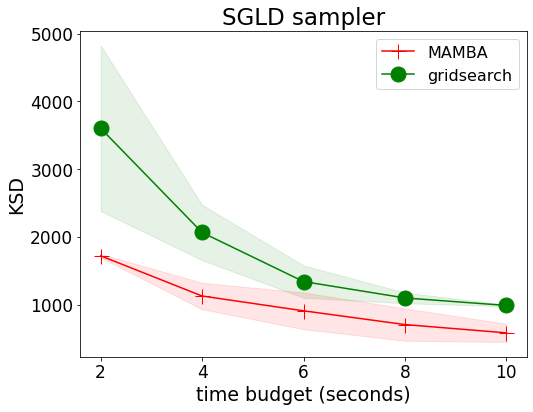

In [31]:
plt.rcParams.update({'font.size':17})

max_time_budget = 8

plt.figure(figsize=(8, 6))

plt.plot(list_time_budget, mean_ksd_curve_sgld_mamba, marker="+", markersize=15, 
         c='r', label="MAMBA")
plt.fill_between(list_time_budget, mean_ksd_curve_sgld_mamba+2*sd_ksd_curve_sgld_mamba, 
                 mean_ksd_curve_sgld_mamba-2*sd_ksd_curve_sgld_mamba, alpha=0.1, color='r')

plt.plot(list_time_budget, mean_ksd_curve_sgld_gridsearch, marker="o", markersize=15, 
         c='g', label="gridsearch")
plt.fill_between(list_time_budget, mean_ksd_curve_sgld_gridsearch+2*sd_ksd_curve_sgld_gridsearch, 
                 mean_ksd_curve_sgld_gridsearch-2*sd_ksd_curve_sgld_gridsearch, alpha=0.1, color='g')

plt.title("SGLD sampler", size=23)
plt.ylabel("KSD", size=19)
plt.xlabel("time budget (seconds)", size=19)
plt.legend(fontsize=16)
# plt.savefig("images/sgld_ksd_curves_R1_R5_n90.png")

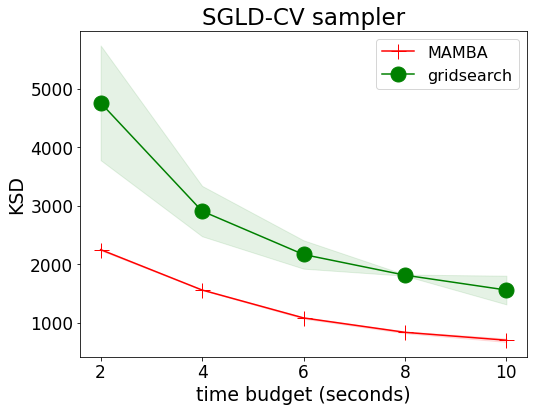

In [32]:
plt.rcParams.update({'font.size':17})

max_time_budget = 8

plt.figure(figsize=(8, 6))

plt.plot(list_time_budget, mean_ksd_curve_sgldCV_mamba, marker="+", markersize=15, 
         c='r', label="MAMBA")
plt.fill_between(list_time_budget, mean_ksd_curve_sgldCV_mamba+2*sd_ksd_curve_sgldCV_mamba, 
                 mean_ksd_curve_sgldCV_mamba-2*sd_ksd_curve_sgldCV_mamba, alpha=0.1, color='r')

plt.plot(list_time_budget, mean_ksd_curve_sgldCV_gridsearch, marker="o", markersize=15, 
         c='g', label="gridsearch")
plt.fill_between(list_time_budget, mean_ksd_curve_sgldCV_gridsearch+2*sd_ksd_curve_sgldCV_gridsearch, 
                 mean_ksd_curve_sgldCV_gridsearch-2*sd_ksd_curve_sgldCV_gridsearch, alpha=0.1, color='g')

plt.title("SGLD-CV sampler", size=23)
plt.ylabel("KSD", size=19)
plt.xlabel("time budget (seconds)", size=19)
plt.legend(fontsize=16)
# plt.savefig("images/sgld_ksd_curves_R1_R5_n90.png")

In [33]:
mean_ksd_curve_sghmc_mamba

array([4819.779 , 3289.6094, 2536.8135, 2124.9565, 1817.9712],
      dtype=float32)

In [34]:
mean_ksd_curve_sghmc_gridsearch

array([11440.311 ,  8862.807 ,  7250.8027,  6127.3296,  5023.1177],
      dtype=float32)

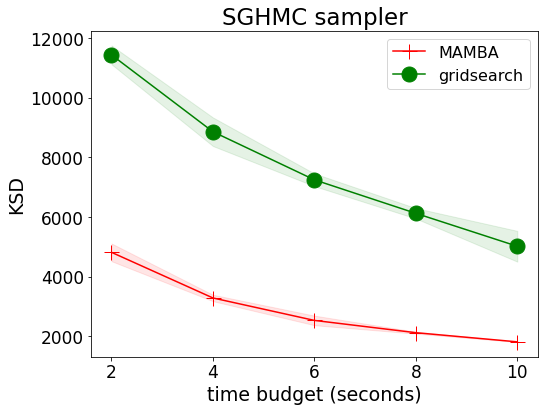

In [35]:
plt.rcParams.update({'font.size':17})

max_time_budget = 8

plt.figure(figsize=(8, 6))

plt.plot(list_time_budget, mean_ksd_curve_sghmc_mamba, marker="+", markersize=15, 
         c='r', label="MAMBA")
plt.fill_between(list_time_budget, mean_ksd_curve_sghmc_mamba+2*sd_ksd_curve_sghmc_mamba, 
                 mean_ksd_curve_sghmc_mamba-2*sd_ksd_curve_sghmc_mamba, alpha=0.1, color='r')

plt.plot(list_time_budget, mean_ksd_curve_sghmc_gridsearch, marker="o", markersize=15, 
         c='g', label="gridsearch")
plt.fill_between(list_time_budget, mean_ksd_curve_sghmc_gridsearch+2*sd_ksd_curve_sghmc_gridsearch, 
                 mean_ksd_curve_sghmc_gridsearch-2*sd_ksd_curve_sghmc_gridsearch, alpha=0.1, color='g')


plt.title("SGHMC sampler", size=23)
plt.ylabel("KSD", size=19)
plt.xlabel("time budget (seconds)", size=19)
plt.legend(fontsize=16)
# plt.savefig("images/sgld_ksd_curves_R1_R5_n90.png")

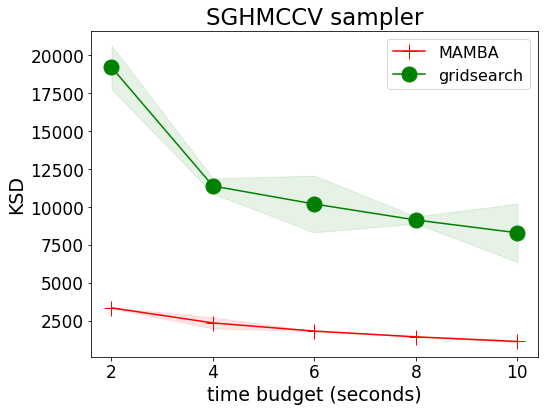

In [36]:
plt.rcParams.update({'font.size':17})

max_time_budget = 8

plt.figure(figsize=(8, 6))

plt.plot(list_time_budget, mean_ksd_curve_sghmcCV_mamba, marker="+", markersize=15, 
         c='r', label="MAMBA")
plt.fill_between(list_time_budget, mean_ksd_curve_sghmcCV_mamba+2*sd_ksd_curve_sghmcCV_mamba, 
                 mean_ksd_curve_sghmcCV_mamba-2*sd_ksd_curve_sghmcCV_mamba, alpha=0.1, color='r')

plt.plot(list_time_budget, mean_ksd_curve_sghmcCV_gridsearch, marker="o", markersize=15, 
         c='g', label="gridsearch")
plt.fill_between(list_time_budget, mean_ksd_curve_sghmcCV_gridsearch+2*sd_ksd_curve_sghmcCV_gridsearch, 
                 mean_ksd_curve_sghmcCV_gridsearch-2*sd_ksd_curve_sghmcCV_gridsearch, alpha=0.1, color='g')


plt.title("SGHMCCV sampler", size=23)
plt.ylabel("KSD", size=19)
plt.xlabel("time budget (seconds)", size=19)
plt.legend(fontsize=16)
# plt.savefig("images/sgld_ksd_curves_R1_R5_n90.png")

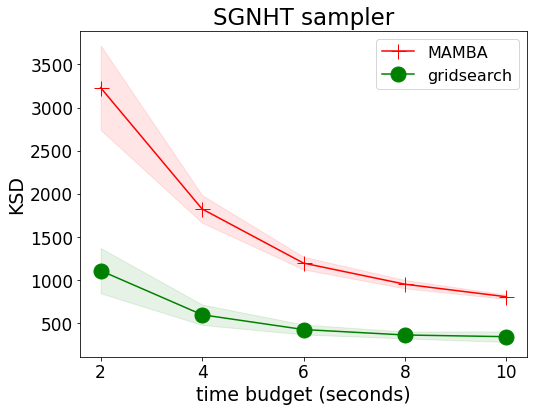

In [37]:
plt.rcParams.update({'font.size':17})

max_time_budget = 8

plt.figure(figsize=(8, 6))

plt.plot(list_time_budget, mean_ksd_curve_sgnht_mamba, marker="+", markersize=15, 
         c='r', label="MAMBA")
plt.fill_between(list_time_budget, mean_ksd_curve_sgnht_mamba+2*sd_ksd_curve_sgnht_mamba, 
                 mean_ksd_curve_sgnht_mamba-2*sd_ksd_curve_sgnht_mamba, alpha=0.1, color='r')

plt.plot(list_time_budget, mean_ksd_curve_sgnht_gridsearch, marker="o", markersize=15, 
         c='g', label="gridsearch")
plt.fill_between(list_time_budget, mean_ksd_curve_sgnht_gridsearch+2*sd_ksd_curve_sgnht_gridsearch, 
                 mean_ksd_curve_sgnht_gridsearch-2*sd_ksd_curve_sgnht_gridsearch, alpha=0.1, color='g')


plt.title("SGNHT sampler", size=23)
plt.ylabel("KSD", size=19)
plt.xlabel("time budget (seconds)", size=19)
plt.legend(fontsize=16)
# plt.savefig("images/sgld_ksd_curves_R1_R5_n90.png")

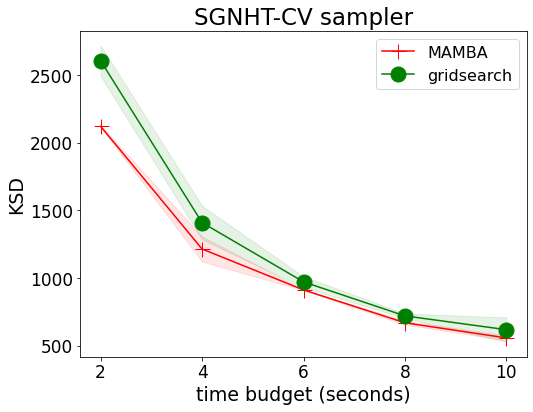

In [38]:
plt.rcParams.update({'font.size':17})

max_time_budget = 8

plt.figure(figsize=(8, 6))

plt.plot(list_time_budget, mean_ksd_curve_sgnhtCV_mamba, marker="+", markersize=15, 
         c='r', label="MAMBA")
plt.fill_between(list_time_budget, mean_ksd_curve_sgnhtCV_mamba+2*sd_ksd_curve_sgnhtCV_mamba, 
                 mean_ksd_curve_sgnhtCV_mamba-2*sd_ksd_curve_sgnhtCV_mamba, alpha=0.1, color='r')

plt.plot(list_time_budget, mean_ksd_curve_sgnhtCV_gridsearch, marker="o", markersize=15, 
         c='g', label="gridsearch")
plt.fill_between(list_time_budget, mean_ksd_curve_sgnhtCV_gridsearch+2*sd_ksd_curve_sgnhtCV_gridsearch, 
                 mean_ksd_curve_sgnhtCV_gridsearch-2*sd_ksd_curve_sgnhtCV_gridsearch, alpha=0.1, color='g')


plt.title("SGNHT-CV sampler", size=23)
plt.ylabel("KSD", size=19)
plt.xlabel("time budget (seconds)", size=19)
plt.legend(fontsize=16)
# plt.savefig("images/sgld_ksd_curves_R1_R5_n90.png")